## Libs

In [1]:
import os
import math
import random #to set the seed to replicate results
from datetime import datetime,timedelta #for today's date
import sys
from pathlib import Path
import requests
import json

import psycopg2
import psycopg2.extras
from psycopg2.extensions import AsIs

import pandas as pd 
import numpy as np #for the e_logarithmic filter (and also some other mathematical operations)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler #for preprocessing, it scales features using statistics that are robust to outliers.
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import tsmoothie #for the Kalman filter, it is an efficient recursive filter that evaluates the state of a dynamic system starting from a series of measurements subject to noise.

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM,Conv1D,MaxPooling1D,Flatten,TimeDistributed #the two main layers of the model
from tensorflow.keras.optimizers import Adam#for the training of the model
from tensorflow.keras.models import load_model

from src import building_data_sequences,sir_parameters,custom_loss_function, \
    plot_model_history,preprare_correction_lstm_table_train,correction_data_sequences, \
    extract_dohlcav_mpnxp_data,filter_and_rename_columns,get_main_dataframe,feature_engineering, \
    mask_train_test_validation, apply_pretreatment,model_cnn_lstm_v1,consume_model,calculate_analytical_parameters,\
    calculate_position_day_number_split, fit_vertical_correction,fit_swing_correction,fit_horizontal_correction_regression, \
    apply_horizontal_correction

random.seed(42)  #set the seed to replicate results

pd.options.display.max_columns = None

plt.style.use('ggplot')
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4)
)

plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=20,
    titlepad=10
)

print(tf.config.list_physical_devices('GPU'))

2024-02-10 15:59:14.941990: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 15:59:15.666427: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 15:59:15.670226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 15:59:17.489634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]


## Configurations

### Bots Configs

In [2]:
headers = {
            'Accept-Encoding': 'gzip, deflate, br',
            'Content-Type': 'application/json',
            'Accept': 'application/json',
            'Connection': 'keep-alive',
            'DNT': '1'
        }

tpc_url = "http://3.64.122.73:6000/graphql"

### Define Case

In [3]:
case = 'TSLA'
'''This is the timestep which indicates the window size'''
model_case_version_time_steps= '10'
'''This is the number of periods defined in the target(MPNxP) where x is the number of periods'''
model_case_version_main_target_code='5'
main_target_code_integer = int(model_case_version_main_target_code)
model_case_version_time_steps_integer = int(model_case_version_time_steps)
targets =['MPN'+model_case_version_main_target_code+'P']

''' This comprises the list of target in our datasets'''
targets_list=["MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods",
                        "HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods",
                        "LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods",
                        'HPN1P_high_price_next_1_period','LPN1P_low_price_next_1_period']

for i in targets_list:
  if targets[0] in i:
    main_target_column=i

### Train Test Validation Dates

In [4]:
#Train test/validation dates
today = datetime.today().strftime('%Y%m%d')
dataset_start_date = pd.Timestamp('2020-01-01')
train_end_date = pd.Timestamp("2023-11-30")
test_end_date = pd.Timestamp('2023-12-31')
#test_end_date = None
validation_end_date= pd.Timestamp("2024-01-31")

### Paths

In [5]:
ROOT = Path('/home/ubuntu/LMB_Bot/LMB-Learning_Model_Builder.Engine_0.03/LMB_0.03')
MODELS = ROOT / 'models'
MODEL_PATH = MODELS / (case + f'_{train_end_date.date().year}_{train_end_date.month_name().upper()}')
MODEL_NAME = 'LSTM_CNN.h5'

### Database Configurations

In [6]:
''' Conection to PostgreSQL '''
# The credentials to conect to the database
hostname = 'database-1.ctzm0hf7fhri.eu-central-1.rds.amazonaws.com'
database = 'dyDATA_new'
username = 'postgres'
pwd = 'Proc2023awsrdspostgresql'
port_id = 5432
conn = None

### Analytical Parameters

In [7]:
#1L = dispersion = 1
#4L = slope + intercept + resqr + dispersion = 1
#5L = all the weighting = 1
#new paramaters case = intercept + slope + end intercept + correlation + dispersion

slope_weighting_exponent_ratio = 1
intercept_weighting_exponent_ratio = 1
end_intercept_weighting_exponent_ratio = 0
rsqr_weighting_exponent_ratio = 1
dispersion_weighting_exponent_ratio = 3

slope_weighting_exponent_predicted_actual = 0
intercept_weighting_exponent_predicted_actual = 0
rsqr_weighting_exponent_predicted_actual = 0
dispersion_weighting_exponent_predicted_actual = 0

analytical_parametrs = str(intercept_weighting_exponent_ratio)+str(slope_weighting_exponent_ratio)+str(end_intercept_weighting_exponent_ratio)+str(rsqr_weighting_exponent_ratio)+str(dispersion_weighting_exponent_ratio)

### Model Configurations

In [8]:
'''These are the exponent used to define the number of nodes for each layer'''
twoexp_nodes_number_layer_1 = 7
twoexp_nodes_number_layer_2 = 10
twoexp_nodes_number_layer_3 = 7
twoexp_nodes_number_layer_4 = 6
twoexp_nodes_number_layer_5 = 0

'''Model compile parameters'''
lr=0.0005
attenuated_padding_value = 1
optimizer = Adam(learning_rate=lr)
loss = custom_loss_function(attenuated_padding_value)
metrics = None

'''Model fit parameters'''
n_epochs = 100
batch = 64

### Train Configurations

In [9]:
train = False
save_model = True
validation_data = 'test'

## Data Prep

### Filtering and Renaming Columns

In [10]:
dohlcav_mpnxp_data = extract_dohlcav_mpnxp_data(case=case,dataset_start_date=dataset_start_date)
dohlcav_mpnxp_data = filter_and_rename_columns(dohlcav_mpnxp_data,targets,model_case_version_main_target_code)

dataframe = get_main_dataframe(dohlcav_mpnxp_data,model_case_version_main_target_code)

/home/ubuntu/LMB_Bot/LMB-Learning_Model_Builder.Engine_0.03/LMB_0.03/notebooks/src/utils.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframe = pd.read_sql(asset_script,conn)


['cleaned_raw_features_id', 'cleaned_raw_features_DCP_date_current_period', 'calculated_features_DNCP', 'cleaned_raw_features_OPCP_open_price_current_period', 'cleaned_raw_features_HPCP_high_price_current_period', 'cleaned_raw_features_LPCP_low_price_current_period', 'cleaned_raw_features_CPCP_close_price_current_period', 'cleaned_raw_features_ACPCP_adjusted_close_price_current_period', 'cleaned_raw_features_VTCP_volume_of_transactions_current_period', 'calculated_targets_MPN5P', 'calculated_targets_HPN5P', 'calculated_targets_LPN5P', 'calculated_targets_HPN1P', 'calculated_targets_LPN1P']


### Feature Engineering

In [11]:
base_target_code = 'MPN' + model_case_version_main_target_code + 'P'
base_target_column_index = dataframe.columns.get_loc(base_target_code)

dataframe = feature_engineering(dataframe,base_target_code,base_target_column_index,model_case_version_main_target_code,targets)

dataframe.head()

,DATE,DNCP,OPCP,HPCP,LPCP,CPCP,ACPCP,OPCP_Ratio,HPCP_Ratio,LPCP_Ratio,ACPCP_Ratio,VTCP,MPN5P_Ratio,MPN5P,MPN-1P,MPN-2P,MPN-3P,MPN-4P,MPN-5P,HPN5P_Ratio,HPN5P,LPN5P_Ratio,LPN5P,hpn1p,hpn1p_Ratio,lpn1p,lpn1p_Ratio
5,2020-01-09,43839.0,33.140000,33.253334,31.524668,32.089333,32.089333,1.032742,1.036274,0.982403,1.0,426606020.0,1.078098,34.297333,33.933166,32.809334,32.119330,31.580000,30.924166,1.137263,36.49400,0.984128,31.580000,32.329334,1.007479,31.580000,0.984128
6,2020-01-10,43840.0,32.119330,32.329334,31.580000,31.876667,31.876667,1.007613,1.014201,0.990693,1.0,194392500.0,1.069276,34.378000,34.297333,33.933166,32.809334,32.119330,31.580000,1.144850,36.49400,1.028966,32.800000,35.042000,1.099299,32.800000,1.028966
7,2020-01-13,43843.0,32.900000,35.042000,32.800000,34.990665,34.990665,0.940251,1.001467,0.937393,1.0,397764000.0,1.066993,34.993332,34.378000,34.297333,33.933166,32.809334,32.119330,1.045193,36.57200,0.937717,32.811333,36.494000,1.042964,34.993332,1.000076
8,2020-01-14,43844.0,36.284000,36.494000,34.993332,35.861332,35.861332,1.011786,1.017642,0.975796,1.0,434943000.0,1.049205,35.048167,34.993332,34.378000,34.297333,33.933166,32.809334,1.105183,39.63333,0.914950,32.811333,35.856000,0.999851,34.452667,0.960719
9,2020-01-15,43845.0,35.317333,35.856000,34.452667,34.566666,34.566666,1.021716,1.037300,0.996702,1.0,260532000.0,1.034253,35.907333,35.048167,34.993332,34.378000,34.297333,33.933166,1.146577,39.63333,0.949219,32.811333,34.297333,0.992208,32.811333,0.949219


### Train Test Validation Masks

In [12]:
(train_mask,
 test_mask,
 validation_mask,
 train_end_idx,
 train_end_new_idx,
 train_new_end_date,
 test_start_date,
 validation_start_date) = mask_train_test_validation(dohlcav_mpnxp_data,
                                                     dataset_start_date,
                                                     train_end_date,
                                                     test_end_date,
                                                     validation_end_date,
                                                     model_case_version_main_target_code)

Train size: 986
Test size: 1006
Validation mask: 1027


### Train Test Validation Split

In [13]:
#train_df = dataframe.iloc[main_target_code_integer:train_end_new_idx+1,:]
train_df = dataframe.iloc[:train_end_new_idx+1]
if test_end_date:
    test_df = dataframe[test_mask]
    validation_df = dataframe[validation_mask]
else:
    validation_df = dataframe[validation_mask]
    test_df = None

/tmp/ipykernel_1578/4138781052.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = dataframe[test_mask]
/tmp/ipykernel_1578/4138781052.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  validation_df = dataframe[validation_mask]


In [14]:
train_actual_target_list = train_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')
validation_actual_target_list = validation_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')
if isinstance(test_df,pd.DataFrame):
    test_actual_target_list = test_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')

### Prettreatment

In [15]:
features_start_index = 1
features_stop_index = 13

(train_df,
test_df,
validation_df,
train_df_features,
train_df_targets,
test_df_features,
test_df_targets,
validation_df_features,
validation_df_targets,
train_dates_np_arr,
validation_dates_np_arr,
test_dates_np_arr,
robust_scaler_features,
robust_scaler_targets,
features,
targets,
features_and_targets) = apply_pretreatment(train_df,test_df,validation_df,features_start_index,features_stop_index,model_case_version_main_target_code) 


Features and Targets:  ['DNCP', 'OPCP', 'HPCP', 'LPCP', 'CPCP', 'ACPCP', 'OPCP_Ratio', 'HPCP_Ratio', 'LPCP_Ratio', 'ACPCP_Ratio', 'VTCP', 'MPN5P_Ratio', 'MPN5P', 'MPN-1P', 'MPN-2P', 'MPN-3P', 'MPN-4P', 'MPN-5P']
Features List:  ['DNCP', 'OPCP', 'HPCP', 'LPCP', 'CPCP', 'ACPCP', 'OPCP_Ratio', 'HPCP_Ratio', 'LPCP_Ratio', 'ACPCP_Ratio', 'VTCP', 'MPN5P_Ratio']
Targets List:  ['MPN5P', 'MPN-1P', 'MPN-2P', 'MPN-3P', 'MPN-4P', 'MPN-5P']


## Prediction Model Training

### Prepare Inputs

In [16]:
train_df_features

,DNCP,OPCP,HPCP,LPCP,CPCP,ACPCP,OPCP_Ratio,HPCP_Ratio,LPCP_Ratio,ACPCP_Ratio,VTCP,MPN5P_Ratio
DATE,,,,,,,,,,,,
2020-01-09,-3.741630,-3.701491,-3.677354,-3.677638,-3.682846,-3.681719,-3.695205,-3.359820,-0.238233,0.953667,0.335048,-2.355050
2020-01-10,-3.772095,-3.729923,-3.700598,-3.696130,-3.709527,-3.742879,-3.897785,-4.120879,-1.660746,-0.597765,-1.075676,-3.295522
2020-01-13,-3.701532,-3.645357,-3.602070,-3.593304,-3.595402,-3.618850,-3.738441,-3.633078,-0.665031,0.650898,0.148143,-2.440482
2020-01-14,-3.561679,-3.517886,-3.490299,-3.485652,-3.487688,-3.487711,-3.509547,-3.194179,-0.195687,0.947200,0.340143,-2.328341
2020-01-15,-3.596226,-3.554609,-3.526634,-3.524209,-3.534015,-3.548241,-3.623187,-3.576790,-0.983855,0.010952,-0.546276,-2.923311
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,0.133526,0.113214,0.107852,0.107911,0.102038,0.089195,0.054744,-0.184306,-0.568039,-0.764231,-0.623450,-0.284897
2023-11-27,0.137329,0.116417,0.107980,0.108194,0.107581,0.110855,0.141532,0.183441,0.201301,0.121677,0.204010,0.278991
2023-11-28,0.154000,0.140447,0.140025,0.142021,0.146006,0.150322,0.182405,0.326139,0.524204,0.558118,0.641076,0.574014


In [17]:
train_features_arr = train_df_features.to_numpy(dtype='float64')
train_targets_arr = train_df_targets.to_numpy(dtype='float64')

validation_features_arr = validation_df_features.to_numpy(dtype='float64')
validation_targets_arr = validation_df_targets.to_numpy(dtype='float64')

if isinstance(test_df,pd.DataFrame):
    test_features_arr = test_df_features.to_numpy(dtype='float64')
    test_targets_arr = test_df_targets.to_numpy(dtype='float64')

X_train, y_train = building_data_sequences(train_features_arr,train_targets_arr,timesteps=model_case_version_time_steps_integer)
X_validation, y_validation =  building_data_sequences(validation_features_arr,validation_targets_arr,timesteps=model_case_version_time_steps_integer)

if isinstance(test_df,pd.DataFrame):
    X_test,y_test = building_data_sequences(test_features_arr,test_targets_arr,timesteps=model_case_version_time_steps_integer)

print('\n')
print(f'X train shape : {X_train.shape}')
print(f'y train shape : {y_train[0].shape}')
print('\n')
if isinstance(test_df,pd.DataFrame):
    print(f'X test shape : {X_test.shape}')
    print(f'y test shape : {y_test[0].shape}')
    print('\n')
print(f'X val shape : {X_validation.shape}')
print(f'y val shape : {y_validation[0].shape}')
print('\n')

input_shape=((X_train).shape[1],(X_train).shape[2])
print("Input shape obtained is:",input_shape)



X train shape : (972, 10, 12)
y train shape : (972, 6)


X test shape : (992, 10, 12)
y test shape : (992, 6)


X val shape : (1013, 10, 12)
y val shape : (1013, 6)


Input shape obtained is: (10, 12)


### Define the Model and Train

In [18]:
if train:
    val_dict = {
        'train':(X_train,y_train),
        'validation':(X_validation,y_validation),
        'test':(X_test,y_test)
    }

    prediction_model = model_cnn_lstm_v1(
        input_shape,optimizer,attenuated_padding_value,
            twoexp_nodes_number_layer_1,twoexp_nodes_number_layer_2,
            twoexp_nodes_number_layer_3,twoexp_nodes_number_layer_4,
            model_case_version_main_target_code
    )

    model_history = prediction_model.fit(
        X_train,
        y_train,
        batch_size=batch,
        epochs=n_epochs,
        validation_data=val_dict[validation_data]
    )

    if save_model:
        prediction_model.save(MODEL_PATH / MODEL_NAME)

else:
    prediction_model = load_model(MODEL_PATH / MODEL_NAME,compile=False)
    print(
        prediction_model.summary()
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 7, 64)             3136      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 64)             0         
 g1D)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 3, 128)            98816     
                                                                 
 lstm_4 (LSTM)               (None, 3, 1024)           4722688   
                                                                 
 lstm_5 (LSTM)               (None, 128)               590336    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                      

### Prediction and Evaluation

In [19]:
# Predictions
train_predictions = consume_model(prediction_model,X_train,robust_scaler_targets)
test_predictions = consume_model(prediction_model,X_test,robust_scaler_targets)
validation_predictions = consume_model(prediction_model,X_validation,robust_scaler_targets)

#Evaluation
train_analytical_parameters = calculate_analytical_parameters(train_actual_target_list,train_predictions)
test_analytical_parameters = calculate_analytical_parameters(test_actual_target_list,test_predictions)
validation_analytical_parameters = calculate_analytical_parameters(validation_actual_target_list,validation_predictions)

print('Train scores',train_analytical_parameters)
print('Test scores',test_analytical_parameters)
print('Validation scores', validation_analytical_parameters)

32/32 [==============================] - 0s 13ms/step
Train scores {'slope': 0.554206254982879, 'intercept': 90.47186022039998, 'rvalue': 0.925359466362035, 'dispersion': 0.08285401721037064}
Test scores {'slope': 0.5551479091338886, 'intercept': 90.49304421396421, 'rvalue': 0.9252327847998429, 'dispersion': 0.08215345681932557}
Validation scores {'slope': 0.5546098556558398, 'intercept': 90.43088269231588, 'rvalue': 0.9249824022210954, 'dispersion': 0.08123283469881458}


## Corrections (Vertical,Swing,Horizontal)

In [20]:
df_actual = dataframe.iloc[model_case_version_time_steps_integer-1:,:].reset_index(drop=True)
df_actual = df_actual.set_index('DATE')
actual_targets = []
for target in targets:
    actual_targets.append(np.array(df_actual[target].astype(float)))

positions_day_number_train = calculate_position_day_number_split(dohlcav_mpnxp_data,train_mask,model_case_version_time_steps_integer,main_target_code_integer)
positions_day_number_test = calculate_position_day_number_split(dohlcav_mpnxp_data,test_mask,model_case_version_time_steps_integer,main_target_code_integer)
positions_day_number_validation = calculate_position_day_number_split(dohlcav_mpnxp_data,validation_mask,model_case_version_time_steps_integer,main_target_code_integer)
train_actual = actual_targets[0][:len(train_predictions)]

(972,)
(992,)
(1013,)


### Vertical Correction with TPC

In [21]:
fit_vertical_correction_response = fit_vertical_correction(train_actual.tolist(),
                                                           train_predictions.tolist(),
                                                           positions_day_number_train.tolist(),
                                                           tpc_url,
                                                           headers)

corrected_train_raw_targets_ratios = fit_vertical_correction_response['data']['fitVerticalCorrection']['corrected_train_raw_targets_ratios']
train_vertical_corrected_targets = fit_vertical_correction_response['data']['fitVerticalCorrection']['train_vertical_corrected_targets']
vertical_padding_correction_factor = fit_vertical_correction_response['data']['fitVerticalCorrection']['vertical_padding_correction_factor']
train_raw_targets_ratio = fit_vertical_correction_response['data']['fitVerticalCorrection']['train_raw_targets_ratio']

print('corrected_train_raw_targets_ratios: ', corrected_train_raw_targets_ratios[:10])
print('train_vertical_corrected_targets: ', train_vertical_corrected_targets[:10])
print('train_raw_targets_ratio', train_raw_targets_ratio)
print('vertical_padding_correction_factor: ', vertical_padding_correction_factor)

corrected_train_raw_targets_ratios:  [1.5833808385026713, 1.549258764091239, 1.3535696349680324, 1.3207304731714893, 1.2412009818193115, 1.2879502941860672, 1.3371402034589706, 1.366011407279742, 1.5410964294353553, 1.5654518075615436]
train_vertical_corrected_targets:  [60.0090792476128, 59.74742218876285, 57.07732436733199, 57.2818424758987, 58.262800726452376, 63.08380540923357, 66.76430356836231, 70.23848566911843, 78.98530057164282, 80.23357863204807]
train_raw_targets_ratio [2.2911434129223003, 2.241768957881574, 1.9586078583730555, 1.9110897708691106, 1.7960110318735611, 1.8636570311702483, 1.934834560841148, 1.976611034857122, 2.2299581042788614, 2.2652002032143375, 2.129803893635286, 1.995134631328354, 1.9709143303730037, 1.8214231462620976, 1.8205742342079372, 1.8019512553519705, 1.77367972082039, 1.794938335808148, 1.998212430165429, 1.993256506626459, 1.9821031935235205, 2.0629203379011596, 2.0060940545606725, 1.9390421802952804, 1.933918528157111, 1.8801444196376111, 1.921

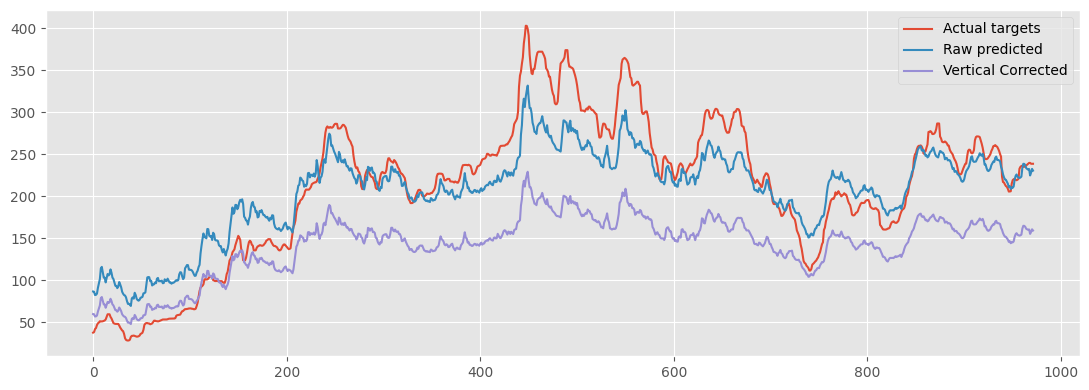

In [22]:
plot_vertical_corrections = True
if plot_vertical_corrections:
    ax = plt.plot(train_actual,label='Actual targets')
    ax = plt.plot(train_predictions,label='Raw predicted')
    plt.plot(train_vertical_corrected_targets,label='Vertical Corrected')

    plt.legend()

### Swing Correction with TPC

In [23]:
fit_swing_correction_response = fit_swing_correction(
    train_actual.tolist(),
    train_vertical_corrected_targets,
    positions_day_number_train.tolist(),
    vertical_padding_correction_factor,
    train_raw_targets_ratio,
    headers,
    tpc_url
)

swing_padding_correction_factors = fit_swing_correction_response['data']['fitSwingCorrection']['swing_padding_correction_factors']
swing_targets_ratios = fit_swing_correction_response['data']['fitSwingCorrection']['swing_targets_ratios']
swing_predicted_train_targets = fit_swing_correction_response['data']['fitSwingCorrection']['swing_predicted_targets']

print('swing_padding_correction_factors', swing_padding_correction_factors[:10])
print('swing_targets_ratios',swing_targets_ratios[:10])
print('swing_predicted_targets', swing_predicted_train_targets[:10])

swing_padding_correction_factors [1.0003382895685329, 1.0006768080941841, 1.001693739740609, 1.0020331764230723, 1.0023728432284023, 1.0027127403906977, 1.0030528681443753, 1.0040746373026408, 1.0044156897723828, 1.0047569740103726]
swing_targets_ratios [1.5839164797233516, 1.5503073149627615, 1.3558622296504592, 1.3234157512307747, 1.2441461571641077, 1.2914441689703167, 1.341222316190674, 1.3715774083156769, 1.5479014331770686, 1.5728986211246045]
swing_predicted_targets [60.02937969313953, 59.78785972770683, 57.17399849990056, 57.398306567490835, 58.40104921862389, 63.254935396166104, 66.96812618390756, 70.52468202290682, 79.33407515554562, 80.6152476803599]


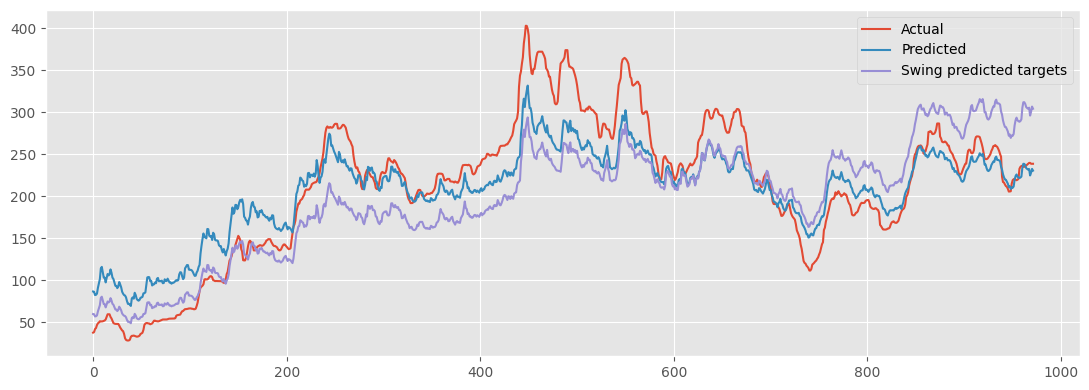

In [24]:
plot_swing_corrections = True
if plot_swing_corrections:
    ax = plt.plot(train_actual,label='Actual')
    ax = plt.plot(train_predictions,label='Predicted')
    plt.plot(swing_predicted_train_targets,label='Swing predicted targets')

    plt.legend()

### Horizontal Correction with TPC

In [25]:
# First fit horizontal correction model
response_fit_horizontal_correction_regression = fit_horizontal_correction_regression(
    swing_predicted_train_targets,
    train_actual.tolist(),
    positions_day_number_train.tolist(),
    tpc_url,
    headers
)

horizontal_correction_model_path = response_fit_horizontal_correction_regression['data']['fitHorizontalPaddingCorrectionRegression']['model_path']
print(horizontal_correction_model_path)

# Apply horizontal corrections
response_apply_horizontal_correction = apply_horizontal_correction(
    train_actual.tolist(),
    swing_predicted_train_targets,
    positions_day_number_train.tolist(),
    horizontal_correction_model_path,
    tpc_url,
    headers
)

horizontal_corrected_train_predictions = response_apply_horizontal_correction['data']['applyHorizontalPaddingCorrection']['horizontal_corrected_swing_targets']
print('horizontal_corrected_train_predictions', horizontal_corrected_train_predictions[:10])

/home/ubuntu/TPC_FIKRI/horizontal_correction_models/linear_regression.joblib
horizontal_corrected_train_predictions [38.05085587381227, 37.89776348068234, 37.02143486161425, 42.45688905686857, 44.24959778303997, 50.95607060724941, 51.987038616372615, 52.73142938919873, 58.015138346127756, 52.28076640439727]


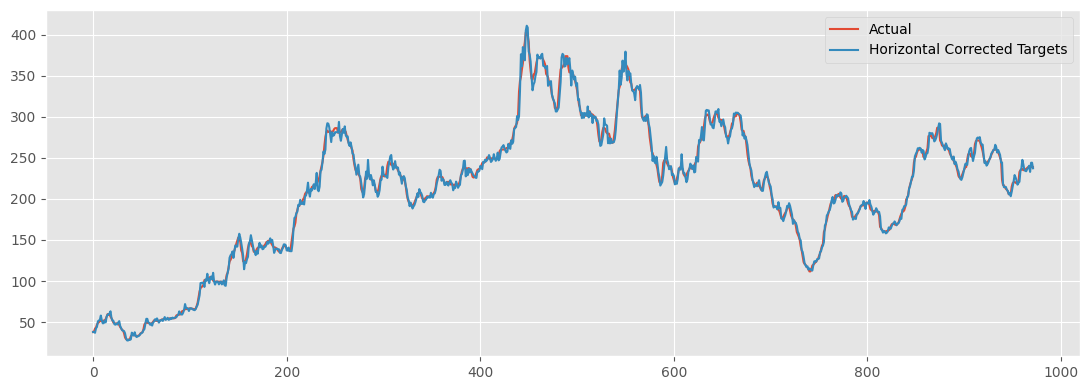

In [26]:
plot_horizontal_corrections = True
if plot_horizontal_corrections:
    ax = plt.plot(train_actual,label='Actual')
    #ax = plt.plot(train_predictions,label='Predicted')
    plt.plot(horizontal_corrected_train_predictions,label='Horizontal Corrected Targets')

    plt.legend()    

In [27]:
mean_absolute_percentage_error(train_actual,horizontal_corrected_train_predictions)

0.019957539460034007

In [28]:
def test_query(swing_predicted_over_past_actual_ratio,swing_predicted_targets,day_number_index,horizontal_correction_model_path,url,headers):
    horizontal_correction_model_path = json.dumps(horizontal_correction_model_path)
    query = f"""
        query {{
            testQuery (
                swing_predicted_over_past_actual_ratio: {swing_predicted_over_past_actual_ratio},
                swing_predicted_targets: {swing_predicted_targets},
                day_number_index: {day_number_index},
                horizontal_correction_model_path:{horizontal_correction_model_path}
            ) {{
                success,
                error,
                horizontal_corrected_predicted_targets
            }}
        }}
    """

    response = requests.post(url,headers=headers,json={'query':query}).json()
    return response

In [29]:
train_actual_df = pd.DataFrame({'train_actual_targets':train_actual},index=positions_day_number_train)
train_actual_df['train_actual_targets_lag_1'] = train_actual_df['train_actual_targets'].shift(1)
train_actual_df.bfill(inplace=True)

swing_predicted_over_past_actual_ratio = swing_predicted_train_targets / train_actual_df['train_actual_targets_lag_1']

response_test_query = test_query(swing_predicted_over_past_actual_ratio.tolist(),
                                 swing_predicted_train_targets,
                                 positions_day_number_train.tolist(),
                                 horizontal_correction_model_path,
                                 tpc_url,
                                 headers)


horizontal_corrected_predicted_targets = response_test_query['data']['testQuery']['horizontal_corrected_predicted_targets']

In [30]:
train_actual_df

,train_actual_targets,train_actual_targets_lag_1
1,37.899334,37.899334
2,38.565166,37.899334
5,42.168000,38.565166
6,43.371334,42.168000
7,46.940666,43.371334
...,...,...
1402,239.753000,238.750000
1405,239.753000,239.753000
1406,238.720000,239.753000
1407,238.720000,238.720000


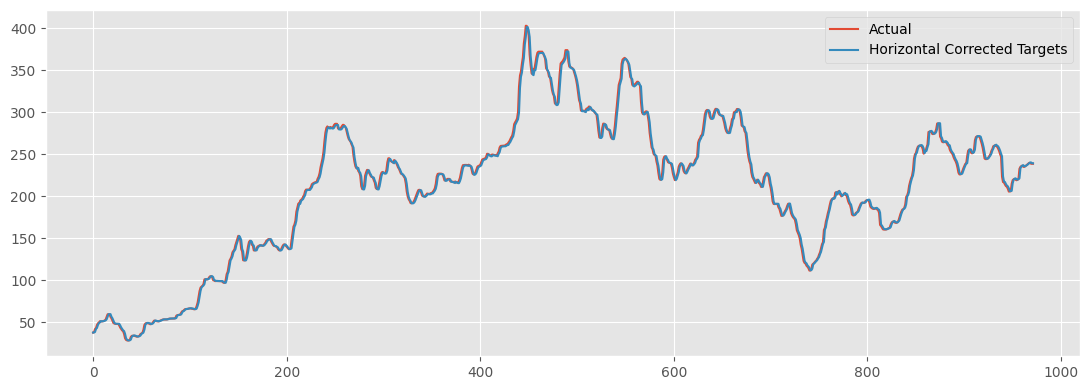

In [31]:
plot_horizontal_corrections = True
if plot_horizontal_corrections:
    ax = plt.plot(train_actual,label='Actual')
    #ax = plt.plot(train_predictions,label='Predicted')
    plt.plot(horizontal_corrected_predicted_targets,label='Horizontal Corrected Targets')

    plt.legend()    

In [32]:
mean_squared_error(train_actual,horizontal_corrected_predicted_targets)

19.28177823196795

In [33]:
mean_absolute_percentage_error(train_actual,horizontal_corrected_predicted_targets)

0.014592672328853216